In [1]:
import logging
import warnings

logging.disable(logging.CRITICAL)
warnings.filterwarnings("ignore")

# Predict Gene Expression Part II: Training and Evaluating the Model

This notebook uses duet evoC data to predict gene expression in mouse embryonic stem cells ES-E14. It uses methylation data in a set of genomic regions (upstream of the TSS, around TSS, gene body, first exon, first intron, exons, introns, 5 and 3' UTRs and downstream region), and learns gene expression from it, using a [public dataset of expression](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE135509). The regions are based on the Gencode annotations, for the mm10 mouse genome.

For each region, we compute a mean 5mC fraction, a mean 5hmC, and record the number of CpGs in the region (regardless of whether they are methylated or not), and the length of the region. This forms a basis of 4 features per region, times 6 regions, hence 24 features.

Note that the regions we selected may have an overlap (in particular promoter, around TSS, and gene body). A natural extension would be to add more regions, mostly all exons and introns (taking the mean across them), and divide the promoter and downstream regions in sub-regions.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyranges as pr
import seaborn as sns

**Note**: This notebook requires the additional Machine Learning library [XGBoost](https://github.com/dmlc/xgboost) to train and evaluate models on `modality` generated data. You can either install it using your favorite Python package, for example Poetry, or uncomment and run the following cell to install using `pip` into the current Python virtual environment. Note that the exclamation mark is required in front of the command.

In [3]:
#! pip install xgboost

In [4]:
from scipy.stats import spearmanr
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    roc_auc_score,
    f1_score,
)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [5]:
sns.set_theme()
sns.set_style("whitegrid")
biomodal_palette = ["#003B49", "#9CDBD9", "#F87C56", "#C0DF16", "#05868E"]
sns.set_palette(biomodal_palette)

In [6]:
column_order = [
    'upstream_2000', 'upstream_1000', 'upstream_500', 'upstream_250', 
    'around_tss', 'five_prime_utrs', 'first_exons', 'first_introns', 
    'exons', 'introns', 'three_prime_utrs', 'genes', 'downstream_1000',
    'downstream_2000', 'downstream_3000', 'downstream_4000', 'cpg_islands',
    ]

## Load features from pickle file

In [7]:
df_features = pd.read_pickle("features.pickle")

The above dataframe is our feature set, containing a series of features (mean 5mC, mean 5hmC, CpG count, and region length) for each of the genomic regions of interest, and for each gene.

## Load gene expression

We use the publicly available ES-E14 bulk RNA-seq data from Alda-Catalinas et al.
(https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE135509):

```
https://ftp.ncbi.nlm.nih.gov/geo/series/GSE135nnn/GSE135509/suppl/GSE135509_Quantified_data_bulk_RNA-seq_E14_and_SAM_mESCs.txt.gz
```

This dataset contains expression for a list of genomic ranges associated particular genes in mm10. The data consists of 3 technical replicates of the same experiment, given in log2(RPM). In the following, we load the data, take the mean of these replicates, and use the length of the gene to convert the data to log2(RPKM). 

In [8]:
def rpm_to_rpkm(rpm, length):
    """
    Convert RPM to RPKM
    """
    return rpm - np.log2(length) + np.log2(1e3)

In [9]:
ge_path = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE135nnn/GSE135509/suppl/GSE135509_Quantified_data_bulk_RNA-seq_E14_and_SAM_mESCs.txt.gz"
# ge_path = "../data/GSE135509_Quantified_data_bulk_RNA-seq_E14_and_SAM_mESCs.txt.gz"
df_expression = pd.read_csv(ge_path, sep="\t")
df_expression.head()

,Gene,Chromosome,Start,End,Orientation,E14_rep_1 (log2 RPM),E14_rep_2 (log2 RPM),E14_rep_3 (log2 RPM),SAM_rep_1 (log2 RPM),SAM_rep_2 (log2 RPM)
0,Xkr4,1,3205901,3671498,-,-1.373860,-2.385950,-1.653259,-0.925966,-2.494504
1,Gm1992,1,3466587,3513553,+,-2.525863,-2.385950,-2.805262,-2.662932,-2.646507
2,Rp1,1,4343507,4360314,-,-2.525863,-2.385950,-2.805262,-2.662932,-2.646507
3,Sox17,1,4490928,4496413,-,-0.373860,-2.385950,-2.805262,-2.662932,-2.646507
4,Mrpl15,1,4773206,4785739,-,6.801065,6.520941,6.820447,6.457738,6.477040


In [10]:
def load_rna_expression(convert_to_rpkm=True):
    rna_data_path = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE135nnn/GSE135509/suppl/GSE135509_Quantified_data_bulk_RNA-seq_E14_and_SAM_mESCs.txt.gz"
    df_expression = pd.read_csv(rna_data_path, sep="\t")

    # revert from log2(RPM) to RPM before taking the mean
    df_expression["E14_rep_1"] = np.power(2, df_expression["E14_rep_1 (log2 RPM)"])
    df_expression["E14_rep_2"] = np.power(2, df_expression["E14_rep_2 (log2 RPM)"])
    df_expression["E14_rep_3"] = np.power(2, df_expression["E14_rep_3 (log2 RPM)"])

    # take the mean of the three replicates
    df_expression["E14_expr"] = np.mean(
        df_expression[["E14_rep_1", "E14_rep_2", "E14_rep_3"]],
        axis=1,
    )

    # log2 transform
    df_expression["Response"] = np.log2(df_expression["E14_expr"])

    # convert to RPKM
    if convert_to_rpkm:
        df_expression["Gene_length"] = df_expression["End"] - df_expression["Start"]
        df_expression["Response"] = rpm_to_rpkm(
            df_expression["Response"], df_expression["Gene_length"]
        )

    # Convert to 0-based
    df_expression["Start"] = df_expression["Start"] - 1
    df_expression["End"] = df_expression["End"] - 1

    return df_expression

In [11]:
df_expression = load_rna_expression()
df_expression.head()

,Gene,Chromosome,Start,End,Orientation,E14_rep_1 (log2 RPM),E14_rep_2 (log2 RPM),E14_rep_3 (log2 RPM),SAM_rep_1 (log2 RPM),SAM_rep_2 (log2 RPM),E14_rep_1,E14_rep_2,E14_rep_3,E14_expr,Response,Gene_length
0,Xkr4,1,3205900,3671497,-,-1.373860,-2.385950,-1.653259,-0.925966,-2.494504,0.385857,0.191319,0.317921,0.298366,-10.607784,465597
1,Gm1992,1,3466586,3513552,+,-2.525863,-2.385950,-2.805262,-2.662932,-2.646507,0.173636,0.191319,0.143065,0.169340,-8.115552,46966
2,Rp1,1,4343506,4360313,-,-2.525863,-2.385950,-2.805262,-2.662932,-2.646507,0.173636,0.191319,0.143065,0.169340,-6.632998,16807
3,Sox17,1,4490927,4496412,-,-0.373860,-2.385950,-2.805262,-2.662932,-2.646507,0.771715,0.191319,0.143065,0.368699,-3.894974,5485
4,Mrpl15,1,4773205,4785738,-,6.801065,6.520941,6.820447,6.457738,6.477040,111.512792,91.833015,113.020957,105.455588,3.072832,12533


Finally we merge our expression data with our list of features, matching them by chromosome, start and end, and only keeping the features for which we were confident in the transcript we selected.

In [12]:
df_features_expression = pd.merge(
    df_features[df_features["selected_transcript"]==True].reset_index(),
    df_expression,
    on=["Chromosome", "Start", "End"],
    how="inner",
)

In [45]:
"Response" in df_features.columns

False

In [13]:
df_features_expression.to_pickle("features_expression.pickle")

In [14]:
df_test = df_features_expression[["Gene_id", "Start", "End", "mean_hmc_exons", "mean_modc_upstream_500", "range_length_cpg_islands", "Response"]]
df_test[df_test["Gene_id"]=="ENSMUSG00000005514.14"]

,Gene_id,Start,End,mean_hmc_exons,mean_modc_upstream_500,range_length_cpg_islands,Response
3778,ENSMUSG00000005514.14,135670032,135735325,0.058492,0.261307,811.0,-1.896277


## Run regressor to predict gene expression

We use [XGBoost](https://xgboost.readthedocs.io/en/stable/parameter.html) to train a regression model to predict RPKM gene expression values. The hyperparameters were selected from a grid search.

We split the implementation into several functions which take care of imputing missing data, split the data into testing and training, doing a grid search of hyperparameters if requested, training the model, evaluating the model, and plotting the model versus observations.

By default, we impute the mean of a feature where there is a NaN. NaNs could appear because of lack of coverage in this region. We decided on imputing a mean instead of a 0 as to not conflate the actual 0's in the features, which correspond to regions containing no methylation.

We split our data between training and testing using a held-out chromosome. By default we use chromosome 8 as the test chromosome, and the rest of the genome for training.

### Define useful functions

In [15]:
def impute_missing_values(
        data_train, 
        data_test, 
        columns_to_keep, 
        missing_values_strategy="impute_mean",
        ):
    """
    Impute missing values in a dataframe
    """
    data_train = data_train.copy()
    data_test = data_test.copy()
    if missing_values_strategy == "drop":
        data_train = data_train[columns_to_keep].dropna()
        data_test = data_test[columns_to_keep].dropna()
    elif missing_values_strategy == "impute_zero":
        data_train = data_train[columns_to_keep].fillna(0)
        data_test = data_test[columns_to_keep].fillna(0)
    elif missing_values_strategy == "impute_mean":
        imputer = SimpleImputer(strategy="mean")
        data_train = imputer.fit_transform(data_train[columns_to_keep])
        data_test = imputer.transform(data_test[columns_to_keep])
        data_train = pd.DataFrame(data_train, columns=columns_to_keep)
        data_test = pd.DataFrame(data_test, columns=columns_to_keep)
    return data_train, data_test

In [16]:
def select_features(features, mod):
    """
    Select features based on the modification type. Only keep the features corresponding to the list `mod`. 
    E.g. if mod="modc", only keep features related to modC, and discard those related to mC and hmC
    """
    if isinstance(mod, str):
        mod = [mod]
    return [f for f in features if any([m in f for m in mod]) or "cpg_count" in f or "range" in f]

In [17]:
from sklearn.model_selection import train_test_split
def stratified_sampling_per_contig(df, target, test_size=0.1):
    test_indices = []

    # Group by contig
    grouped = df.groupby('Chromosome')
    
    for contig, group in grouped:
        # Split the group into train and test
        train, test = train_test_split(
            group,
            #stratify=group[target],
            test_size=test_size,
            random_state=42
        )
        
        test_indices.extend(test.index)
    
    test_set = df.loc[test_indices]
    train_set = df.drop(test_indices)
    
    return train_set, test_set

In [18]:
def split_train_test_data(data, features, target, test_contig, missing_values_strategy="impute_mean"):
    """
    Split the data into training and testing sets using the specified test contig
    """
    if isinstance(test_contig, str):
        test_contig = [test_contig]
    # data_train = data[~data["Chromosome"].isin(test_contig)]
    # data_test = data[data["Chromosome"].isin(test_contig)]
    data_train , data_test = stratified_sampling_per_contig(data, target) #TODO:need to bin target to stratify

    # Check the distribution of TPM in the test set
    print(data_test[target].value_counts()/len(data))
    print('-'*50)
    # Check the distribution of contigs in the test set
    print(data_test['Chromosome'].value_counts()/data['Chromosome'].value_counts())
    print('-'*50)



    # data_train = impute_missing_values(data_train, features + [target], missing_values_strategy)
    # data_test = impute_missing_values(data_test, features + [target], missing_values_strategy)
    data_train, data_test = impute_missing_values(
        data_train, 
        data_test, 
        features + [target], 
        missing_values_strategy
        )
    X_train, y_train = data_train[features], data_train[target]
    X_test, y_test = data_test[features], data_test[target]
    return X_train, X_test, y_train, y_test


In [19]:
def tune_parameters(X_train, y_train):
    """
    Identify the best hyperparameters of the XGBoost regressor using GridSearchCV
    """
    param_grid = {
        "max_depth": [5, 6, 7, 8],
        "n_estimators": [200, 300, 400, 500, 600, 700, 800],
        "subsample": [0.4, 0.5, 0.6],
        "colsample_bytree": [0.75, 0.8, 0.85, 0.9],
        "eta": [0.01, 0.02, 0.03, 0.04, 0.05],
    }
    regressor = xgb.XGBRegressor(eval_metric="rmsle")
    search = GridSearchCV(regressor, param_grid, cv=5, scoring="r2", n_jobs=4).fit(X_train, y_train)
    return search.best_params_


In [20]:
def train_model(X_train, y_train, hyperparameters, random_state=1):
    """ 
    Train an XGBoost regressor using the specified hyperparameters
    """
    regressor = xgb.XGBRegressor(
        random_state=random_state,
        **hyperparameters,
    )
    regressor.fit(X_train, y_train)
    return regressor


In [21]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the performance of the model using the test set
    """
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    spear_r = spearmanr(y_test, y_pred)
    return mse, rmse, mae, r2, spear_r


In [22]:
def plot_results(y_test, y_pred, title):
    """
    Plot the observed vs predicted expression values for the test set
    """
    biomodal_palette = ["#003B49", "#9CDBD9", "#F87C56", "#C0DF16", "#05868E"]
    plt.plot(y_test, y_pred, ".", ms=4, c=biomodal_palette[0])
    # add x=y line
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "--", color=biomodal_palette[2])
    plt.xlabel("Observed Expr. (log2 RPKM)")
    plt.ylabel("Predicted Expr. (log2 RPKM)")
    plt.title(title)
    plt.xlim(min(y_test)-2, max(y_test)+2)
    plt.ylim(min(y_pred)-2, max(y_pred)+2)
    plt.grid(True)
    plt.show()


In [23]:
def run_regressor(
        data, 
        features, 
        mod,
        target, 
        hyperparameters,
        random_state=1, 
        missing_values_strategy="impute_mean", 
        test_contig=None, 
        find_optimal_parameters=False
        ):
    """
    Run the XGBoost regressor using the specified data and parameters
    """

    features = select_features(features, mod)
    
    X_train, X_test, y_train, y_test = split_train_test_data(
        data, 
        features, 
        target, 
        test_contig,
        missing_values_strategy,
        )

    if find_optimal_parameters:
        best_params = tune_parameters(X_train, y_train)
        hyperparameters.update(best_params)

    model = train_model(X_train, y_train, hyperparameters, random_state)

    mse, rmse, mae, r2, spear_r = evaluate_model(model, X_test, y_test)

    df_metrics = pd.DataFrame({
        "mse": [mse],
        "rmse": [rmse],
        "mae": [mae],
        "r2": [r2],
        "spearman": [spear_r[0]],
    })

    y_pred = model.predict(X_test)

    return model, df_metrics, y_test, y_pred


### Run the model

Let's run the model in the case where we want to train a gene expression predictor using mC and hmC methylation levels.

First we need to pass a dictionary of hyperparameters for the XGBoost model, which we obtained through a grid search.

In [24]:
model_hyperparameters = {
    'n_estimators': 500, 
    'max_depth': 6, 
    'colsample_bytree': 0.85, 
    'eta': 0.02, 
    'subsample': 0.6,
    }

Features are all the columns in `df_features_expression` that start with "mean" (e.g., `mean_hmc_introns`), "count" (e.g., `cpg_count_five_prime_utrs`) or "range" (e.g. `range_length_cpg_islands`). 

In [25]:
features = [
    c for c in df_features_expression.columns if c.startswith("mean")
    or c.startswith("cpg_count")
    or c.startswith("range")
    ]

In [26]:
model, df_metrics, y_test, y_pred = run_regressor(
    data=df_features_expression,
    features=features,
    mod = ["mc", "hmc"],
    target="Response",
    hyperparameters=model_hyperparameters,
    random_state=0,
    test_contig=["8"],
    missing_values_strategy="impute_mean",
    find_optimal_parameters=False,
)    

Response
-2.446410    0.000264
-3.524742    0.000176
-4.589516    0.000176
-2.441713    0.000176
-4.831639    0.000176
               ...   
-0.214276    0.000088
-5.247992    0.000088
 0.850592    0.000088
-3.868841    0.000088
-0.984241    0.000088
Name: count, Length: 1138, dtype: float64
--------------------------------------------------
Chromosome
11    0.100144
2     0.100601
4     0.100174
7     0.100257
X     0.100930
5     0.100162
6     0.100503
1     0.100173
3     0.100823
8     0.100427
10    0.100000
17    0.100686
9     0.101990
14    0.101648
16    0.101538
13    0.103203
15    0.102190
19    0.100746
12    0.100775
18    0.101911
Y     0.200000
Name: count, dtype: float64
--------------------------------------------------


The model performs well, as shown by the metrics below:

In [27]:
df_metrics

,mse,rmse,mae,r2,spearman
0,3.127155,1.768376,1.29619,0.752325,0.862026


Let's plot the predictions of the models versus the actual data on the held chromosome 8.

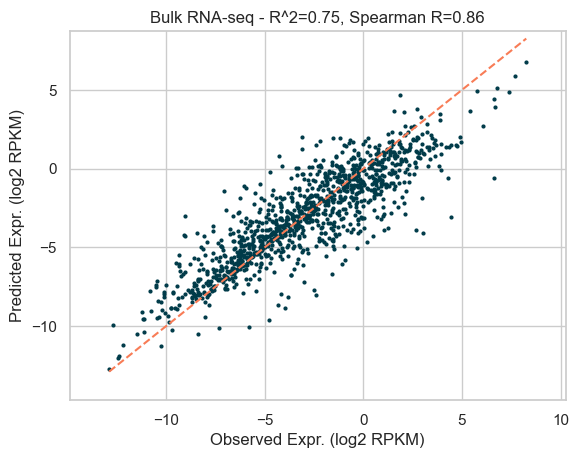

In [28]:
plot_results(
    y_test, 
    y_pred, 
    f"Bulk RNA-seq - R^2={df_metrics.r2.values[0]:.2f}, Spearman R={df_metrics.spearman.values[0]:.2f}"
)

In the above model training, we set a pseudo-random state for reproducibility, but we need to ensure our accuracy estimates are robust to alternative starting random states. Below we train the data again with different pseudo-random states, to get an average value for r^2 and Spearman R.

In [29]:
df_regressor = pd.DataFrame(columns=["mse", "rmse", "mae", "r2", "spearman"])
for k in range(0,20):
    model, df_metrics, _, _ = run_regressor(
        data=df_features_expression,
        features=features,
        mod = ["mc", "hmc"],
        target="Response",
        hyperparameters=model_hyperparameters,
        random_state=k,
        test_contig=["8"],
        missing_values_strategy="impute_mean",
        find_optimal_parameters=False,
    )
    df_regressor = pd.concat([df_regressor, df_metrics], ignore_index=True)
df_regressor = df_regressor.reset_index(drop=True)

Response
-2.446410    0.000264
-3.524742    0.000176
-4.589516    0.000176
-2.441713    0.000176
-4.831639    0.000176
               ...   
-0.214276    0.000088
-5.247992    0.000088
 0.850592    0.000088
-3.868841    0.000088
-0.984241    0.000088
Name: count, Length: 1138, dtype: float64
--------------------------------------------------
Chromosome
11    0.100144
2     0.100601
4     0.100174
7     0.100257
X     0.100930
5     0.100162
6     0.100503
1     0.100173
3     0.100823
8     0.100427
10    0.100000
17    0.100686
9     0.101990
14    0.101648
16    0.101538
13    0.103203
15    0.102190
19    0.100746
12    0.100775
18    0.101911
Y     0.200000
Name: count, dtype: float64
--------------------------------------------------
Response
-2.446410    0.000264
-3.524742    0.000176
-4.589516    0.000176
-2.441713    0.000176
-4.831639    0.000176
               ...   
-0.214276    0.000088
-5.247992    0.000088
 0.850592    0.000088
-3.868841    0.000088
-0.984241    0.000088


The table below shows the average R^2 and Spearman coefficients of the model:

In [30]:
df_regressor[["r2", "spearman"]].describe()

,r2,spearman
count,20.000000,20.000000
mean,0.752536,0.861848
std,0.001475,0.000852
min,0.750287,0.860403
25%,0.751824,0.861395
50%,0.752369,0.861939
75%,0.753131,0.862376
max,0.756836,0.863581


## Classifier

Depending on the biological question you are trying to answer, having a binary classifier may be more than sufficient and you may not need to train a regressor. We can also train such a classifier using [XGBoost](https://xgboost.readthedocs.io/en/stable/). The classifier can be binary (i.e. two categories: high expression and low expression), or have more categories (e.g., we could classify genes as having low expression, moderate expression, or high expression). Having more classes will likely result in a drop in the accuracy of the classifier (since it will have more opportunities to misclassify).

In [31]:
def train_classifier_model(X_train, y_train, hyperparameters, random_state=1):
    """
    Train an XGBoost classifier using the specified hyperparameters
    """
    classifier = xgb.XGBClassifier(
        random_state=random_state,
        **hyperparameters,
    )
    classifier.fit(X_train, y_train)
    return classifier

In [32]:
def evaluate_classifier(model, X_test, y_test):
    """
    Evaluate the performance of the classifier using the test set
    """
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # f1 score
    f1 = f1_score(y_test, y_pred, average="macro")

    # calculate AUC
    if len(np.unique(y_test)) == 2:
        auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    else:
        auc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")

    return accuracy, f1, auc

In [33]:
def run_classifier(
    data,
    features,
    mod,
    target,
    hyperparameters,
    random_state=1,
    missing_values_strategy="impute_mean",
    test_contig=None,
):
    """
    Run an xgboost classifier
    """

    features = select_features(features, mod)
    
    X_train, X_test, y_train, y_test = split_train_test_data(
        data, 
        features, 
        target, 
        test_contig,
        missing_values_strategy,
        )

    classifier = train_classifier_model(X_train, y_train, hyperparameters, random_state)

    accuracy, f1, auc = evaluate_classifier(classifier, X_test, y_test)

    df_metrics = pd.DataFrame(
        {
            "number_of_categories": [len(np.unique(y_train))],
            "accuracy": [accuracy],
            "macro_f1": [f1],
            "auc": [auc],

        }
    )

    return classifier, df_metrics

Loop over the number of categories and evaluate the metrics of the classifier.

In [34]:
df_classifier = pd.DataFrame(columns=["number_of_categories", "accuracy", "macro_f1", "auc"])

number_of_categories = np.arange(2, 6, 1)
for n in number_of_categories:

    # create n categories based on the response values
    labels = [k for k in range(n)]
    df_features_expression["category"] = pd.cut(
        df_features_expression["Response"], bins=n, labels=labels
    )

    # run the classifier
    c, df_metrics = run_classifier(
        data=df_features_expression,
        features=features,
        mod=["mc", "hmc"],
        target="category",
        hyperparameters=model_hyperparameters,
        random_state=1,
        test_contig=["8"],
    )

    df_classifier = pd.concat([df_classifier, df_metrics], ignore_index=True)

category
0    0.059108
1    0.041604
Name: count, dtype: float64
--------------------------------------------------
Chromosome
11    0.100144
2     0.100601
4     0.100174
7     0.100257
X     0.100930
5     0.100162
6     0.100503
1     0.100173
3     0.100823
8     0.100427
10    0.100000
17    0.100686
9     0.101990
14    0.101648
16    0.101538
13    0.103203
15    0.102190
19    0.100746
12    0.100775
18    0.101911
Y     0.200000
Name: count, dtype: float64
--------------------------------------------------
category
1    0.066936
0    0.024277
2    0.009500
Name: count, dtype: float64
--------------------------------------------------
Chromosome
11    0.100144
2     0.100601
4     0.100174
7     0.100257
X     0.100930
5     0.100162
6     0.100503
1     0.100173
3     0.100823
8     0.100427
10    0.100000
17    0.100686
9     0.101990
14    0.101648
16    0.101538
13    0.103203
15    0.102190
19    0.100746
12    0.100775
18    0.101911
Y     0.200000
Name: count, dtype: flo

A binary classifier achieves a good accuracy of 87% and AUC of 0.94. As the number of categories increase, the accuracy and F1 score decrease, since the classifier has more opportunities to misclassify. However, with three categories (i.e., low expression, moderate expression, or high expression) we still retain a robust accuracy of 86%. Note that we report the macro-F1 score, where the F1 score is calculated for each class independently, and the unweighted average of these scores is returned.

In [35]:
df_classifier

,number_of_categories,accuracy,macro_f1,auc
0,2,0.854148,0.848766,0.928496
1,3,0.837555,0.720969,0.929855
2,4,0.774672,0.660797,0.924110
3,5,0.729258,0.649675,0.925865


## Feature importance

### XGboost feature importance

Let's look at the feature importance of our model, first using XGBoost's own `model.feature_importances_` functionality.

In [36]:
df_features_importance = pd.DataFrame(
    {
        "feature": select_features(features, ["mc", "hmc"]),
        "importance": model.feature_importances_,
    }
)

In [37]:
df_features_importance.sort_values("importance", ascending=False).head(10)

,feature,importance
27,mean_hmc_first_exons,0.144654
8,mean_mc_first_exons,0.135655
11,mean_mc_genes,0.068587
68,range_length_genes,0.067242
19,mean_hmc_around_tss,0.060597
9,mean_mc_first_introns,0.037418
49,cpg_count_genes,0.026274
69,range_length_introns,0.024539
20,mean_hmc_cpg_islands,0.023665
28,mean_hmc_first_introns,0.018972


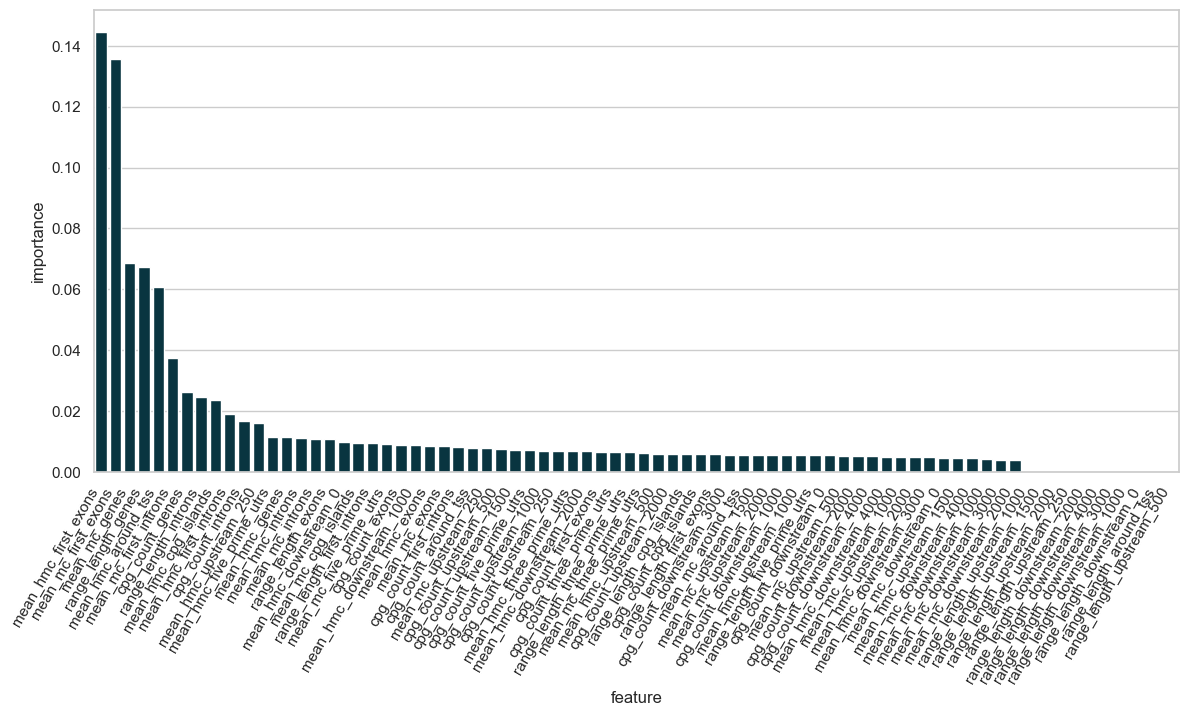

In [38]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(
    x="feature", 
    y="importance", 
    data=df_features_importance.sort_values("importance", ascending=False),
    )
plt.xticks(rotation=60, ha="right")
plt.show()

The length of the upstream, downstream, and around TSS regions are fixed by the user and therefore play little to no importance in the model. 

### Region importance

Instead of looking at the importance of each feature individually, let's try to get some biological insights on which genomic regions bring the most contribution to the performance of the model. In order to do that, we run our regressor on each regions separately, and record their contributions to the R^2.

In [39]:
N_runs = 10
df_regressor = pd.DataFrame(columns=["mse", "rmse", "mae", "r2", "spearman", "Region"])
for region in column_order:
    columns = [f"mean_mc_{region}", f"mean_hmc_{region}", f"cpg_count_{region}", f"range_length_{region}"]
    all_columns = columns + ["Response", "Chromosome"]
    df_one_region = df_features_expression[all_columns]
    for k in range(0, N_runs):
        _, df_metrics, _, _ = run_regressor(
            data=df_one_region,
            features=columns,
            mod=["mc", "hmc"],
            target="Response",
            hyperparameters=model_hyperparameters,
            random_state=k,
            test_contig=["8"],
            missing_values_strategy="impute_mean",
            find_optimal_parameters=False,
        )
        df_metrics["Region"] = region
        df_regressor = pd.concat([df_regressor, df_metrics], ignore_index=True)

Response
-2.446410    0.000264
-3.524742    0.000176
-4.589516    0.000176
-2.441713    0.000176
-4.831639    0.000176
               ...   
-0.214276    0.000088
-5.247992    0.000088
 0.850592    0.000088
-3.868841    0.000088
-0.984241    0.000088
Name: count, Length: 1138, dtype: float64
--------------------------------------------------
Chromosome
11    0.100144
2     0.100601
4     0.100174
7     0.100257
X     0.100930
5     0.100162
6     0.100503
1     0.100173
3     0.100823
8     0.100427
10    0.100000
17    0.100686
9     0.101990
14    0.101648
16    0.101538
13    0.103203
15    0.102190
19    0.100746
12    0.100775
18    0.101911
Y     0.200000
Name: count, dtype: float64
--------------------------------------------------
Response
-2.446410    0.000264
-3.524742    0.000176
-4.589516    0.000176
-2.441713    0.000176
-4.831639    0.000176
               ...   
-0.214276    0.000088
-5.247992    0.000088
 0.850592    0.000088
-3.868841    0.000088
-0.984241    0.000088


Let's see if there are regions where hmC contributes significantly to the performance of the model. In order to visualise this, we repeat the experiment above, this time looking only at region importance for a model with mC but no hmC. 

In [40]:
N_runs = 10
df_regressor_mc_only = pd.DataFrame(columns=["mse", "rmse", "mae", "r2", "spearman", "Region"])
for region in column_order:
    columns = [f"mean_mc_{region}", f"cpg_count_{region}", f"range_length_{region}"]
    all_columns = columns + ["Response", "Chromosome"]
    df_one_region = df_features_expression[all_columns]
    for k in range(0, N_runs):
        _, df_metrics, _, _ = run_regressor(
            data=df_one_region,
            features=columns,
            mod="mc",
            target="Response",
            hyperparameters=model_hyperparameters,
            random_state=k,
            test_contig=["8"],
            missing_values_strategy="impute_mean",
            find_optimal_parameters=False,
        )
        df_metrics["Region"] = region
        df_regressor_mc_only = pd.concat([df_regressor_mc_only, df_metrics], ignore_index=True)

Response
-2.446410    0.000264
-3.524742    0.000176
-4.589516    0.000176
-2.441713    0.000176
-4.831639    0.000176
               ...   
-0.214276    0.000088
-5.247992    0.000088
 0.850592    0.000088
-3.868841    0.000088
-0.984241    0.000088
Name: count, Length: 1138, dtype: float64
--------------------------------------------------
Chromosome
11    0.100144
2     0.100601
4     0.100174
7     0.100257
X     0.100930
5     0.100162
6     0.100503
1     0.100173
3     0.100823
8     0.100427
10    0.100000
17    0.100686
9     0.101990
14    0.101648
16    0.101538
13    0.103203
15    0.102190
19    0.100746
12    0.100775
18    0.101911
Y     0.200000
Name: count, dtype: float64
--------------------------------------------------
Response
-2.446410    0.000264
-3.524742    0.000176
-4.589516    0.000176
-2.441713    0.000176
-4.831639    0.000176
               ...   
-0.214276    0.000088
-5.247992    0.000088
 0.850592    0.000088
-3.868841    0.000088
-0.984241    0.000088


Let's merge the two expereriments and plot the results.

In [41]:
df_regressor_mc_only["features"] = "mc_only"
df_regressor["features"] = "mc+hmc"
df_regions = pd.concat([df_regressor, df_regressor_mc_only])

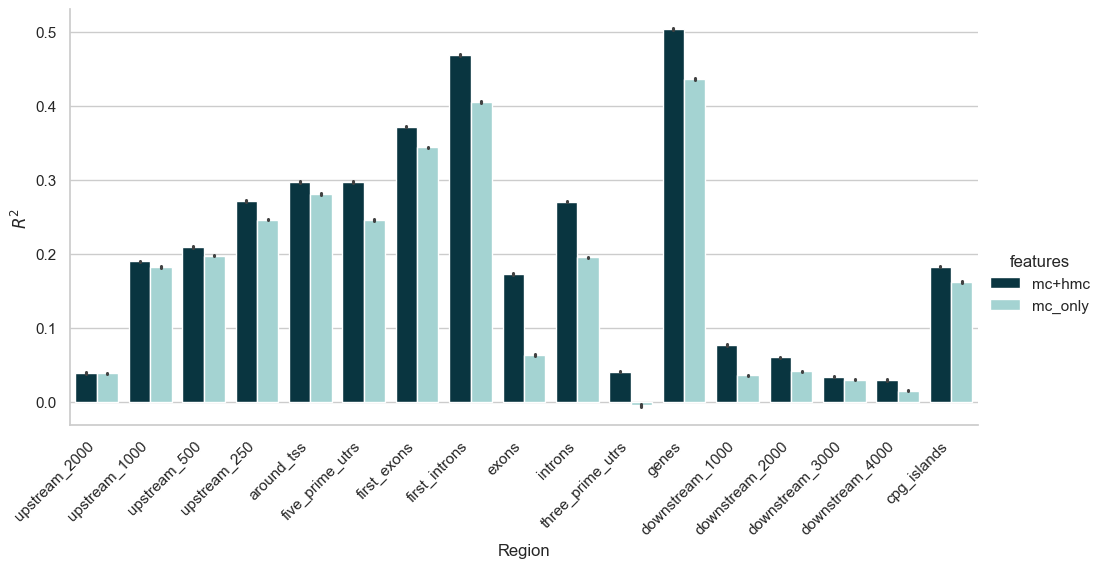

In [42]:
sns.catplot(
    data=df_regions,
    x="Region",
    y="r2",
    hue="features",
    kind="bar",
    palette=biomodal_palette,
    height=5,
    aspect=2,
)
plt.xticks(rotation=45, ha="right")
plt.ylabel(r"$R^2$")
plt.show()

From the plot above we can draw a few conclusions:
- The results show that the model performs better when using both mC and hmC features compared to using only mC features. 
- As we get further from the gene in either direction (upstream or downstream), the contribution of the feature to gene expression decreases.
- Some regions inside the genes, in particular exons and 3'UTRs, do not significantly contribute to gene expression.

In summary, this series of notebooks illustrates how `modality` can help constructing robust machine learning models. It achieves this by condensing methylation data across genomic ranges specified by external annotations, and efficiently grouping them together to generate feature sets, thereby facilitating the model-building process.

This notebook also highlights that the methylation signal obtained from evoC data contains sufficient information to make robust gene expression predictions.